# Data Cleaning and Exploratory Data Analysis (EDA)

In this notebook, I perform data cleaning and data exploration on the dataset. 

Contents:
- [Imports](#Import-libraries-and-data)
- [Data Cleaning](#Data-formatting-and-cleaning)
- [Data Exploration](#Data-exploration)
  - [Numerical variables](#Numerical-variables)
  - [Categorical variables](#Categorical-variables)
- [Save data](#Save-data)

### Import libraries and data

In [287]:
#import libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from pandas_profiling import ProfileReport
pd.set_option('display.max_rows',None)

%matplotlib inline

In [288]:
#import data
trx = pd.read_excel('../data/superstore-trx.xlsx')
print("==================== Top 5 rows of dataset ====================")
display(trx.head())
print("==================== Shape of dataset ====================")
print(trx.shape)
print("==================== Data types in dataset ====================")
print(trx.dtypes)

==================== Top 5 rows of dataset ====================


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.77,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


==================== Shape of dataset ====================
(51290, 24)
==================== Data types in dataset ====================
Row ID                     int64
Order ID                  object
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Ship Mode                 object
Customer ID               object
Customer Name             object
Segment                   object
Postal Code              float64
City                      object
State                     object
Country                   object
Region                    object
Market                    object
Product ID                object
Category                  object
Sub-Category              object
Product Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
Shipping Cost            float64
Order Priority            object
dtype: object


Generate a pandas profiling report for a preliminary review of the dataset.

In [289]:
# generate html summary report about dataset
# report = ProfileReport(trx)
# report.to_file(output_file = 'trx.html')
# print("Report is ready for analysis!")

**Observations based on pandas profiling report :**

1. `Order Date` shows some seasonality which will be further analysed later. I would expect `Ship Date` to follow the same seasonality. `Order Date` can be interpreted as the transaction date from which we can infer recency of transactions made by a particular consumer. 


2. `Ship Mode` has four types of categories : Standard Class, Second Class, First Class and Same Day, which is indicative of the priority of the shipment. A large proportion of the transactions are of Standard Class. 


3. `Customer ID` is unique to the `Customer Name` and `Order ID`. There are 796 distinct customers which means that there are repeated purchases for these customers in this dataset. We can infer frequency of transactions for each of these customers. 


4. `Segment` is a categorical variable. There are three categories of transactions : Consumer, Corporate or Home Office. A large proportion of transactions are consumer-based. 


5. There is >80% missing data in `Postal Code`. While the postal code (indicative of area the customer resides in) may provide insights to the types of purchases made by residents living in the area, there is too little data (~20%) to extract insights from. Further, insights made from location of customer, can be inferred from other features like city and state. So I drop this column. Apart from postal code, there are no other missing values in other columns.


6. `City`, `State`, `Country`, `Region` and `Market` are location-based features. There are 5 markets, 23 regions, 165 countries, 1,102 states and 3,650 cities in the dataset. Profit is a measure of revenue and quantity. We will explore which areas are more profitable than others or order larger quantities than others. 


7. `Product ID` is unique to each `Product Name`. As product name is more interpretable, I will drop `Product ID`.


8. There are 3 types under `Category` : office suppliers, technology and furniture. A large proportion of the transactions fall under office supplies, compared to technology and furniture. From these categories, there are a total of 17 subcategories, with binders, storage and art being the most purchased. 


9. `Sales` show some extrreme values and has a right-skewed distribution. I will normalise this distribution and deal with outliers below. Similarly, `Quantity` shows a right-skewed distribution, which will also be normalised prior to modelling. `Discount` and `Profit` has 50% zeros and 1.3% zeros respectively. This means that almost half of the transactions are discounted. The distribution for `Profit` is slightly right-skewed where transactions are mostly losses than profits. `Profit`, `Sales` and `Quantity` will be used as metrics to identify the more profitable groups. 


10. `Shipping cost` may not be as relevant in our analysis. `Order priority` is categorical with 4 categories : low, medium, high, and critical. A majority of the transactions fall under medium order priority. 

### Data formatting and cleaning
Feature names are reformatted and columns with null values are dealt with here, along with abovementioned columns which are to be removed. 

In [290]:
# create a function that reformats column names 
def reformat_cols(df):
    '''function that reformats dataframe columns for ease of coding'''
    df.columns = [x.lower().replace(" ", "_").replace("-","_") for x in df.columns]
    return df.columns

In [291]:
reformat_cols(trx)

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'postal_code', 'city',
       'state', 'country', 'region', 'market', 'product_id', 'category',
       'sub_category', 'product_name', 'sales', 'quantity', 'discount',
       'profit', 'shipping_cost', 'order_priority'],
      dtype='object')

In [292]:
# drop columns 
trx = trx.drop(columns = ['postal_code', 'product_id'], axis = 1)

### Data exploration

<u>Seasonality<u>

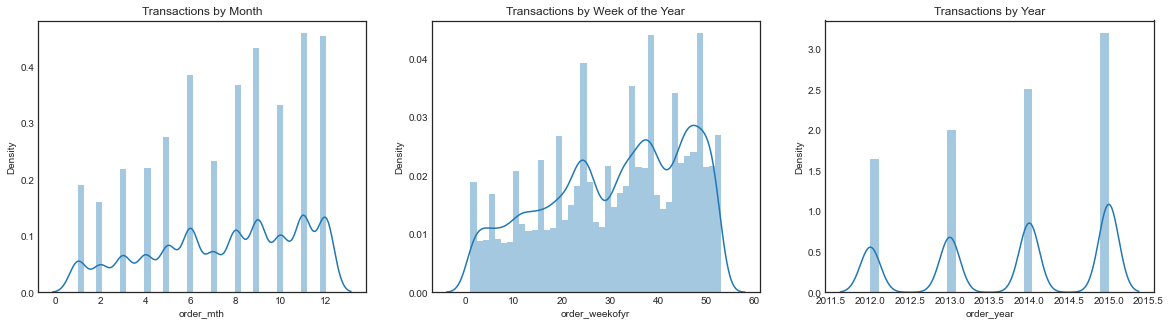

In [293]:
# extract date details from order date
trx['order_mth'] = trx['order_date'].apply(lambda x: x.month)
trx['order_year'] = trx['order_date'].apply(lambda x: x.year)
trx['order_weekofyr'] = trx['order_date'].apply(lambda x: x.weekofyear)
# plot distribution of transactions over the years, by month, week and year
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize =(20,5))
sns.distplot(ax = axes[0], a=trx.order_mth)
axes[0].set_title("Transactions by Month")
sns.distplot(ax = axes[1], a=trx.order_weekofyr)
axes[1].set_title("Transactions by Week of the Year")
sns.distplot(ax = axes[2], a=trx.order_year)
axes[2].set_title("Transactions by Year")
plt.show();

Overall volume of transactions increase over the years from 2012 to 2015. There is also clear seasonality in sales, where months with the highest volume of transactions in *June, September, November* and *December*. This is expected with Christmas season and bonus payout towards the end of the year. 

<u> Unit Price </u>

In [294]:
# compute unit price based on sales and quantity
trx['unit_price'] = trx['sales'] / trx['quantity']

<u> Visualisation by Categories </u>

In [295]:
trx.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'city', 'state', 'country',
       'region', 'market', 'category', 'sub_category', 'product_name', 'sales',
       'quantity', 'discount', 'profit', 'shipping_cost', 'order_priority',
       'order_mth', 'order_year', 'order_weekofyr', 'unit_price'],
      dtype='object')

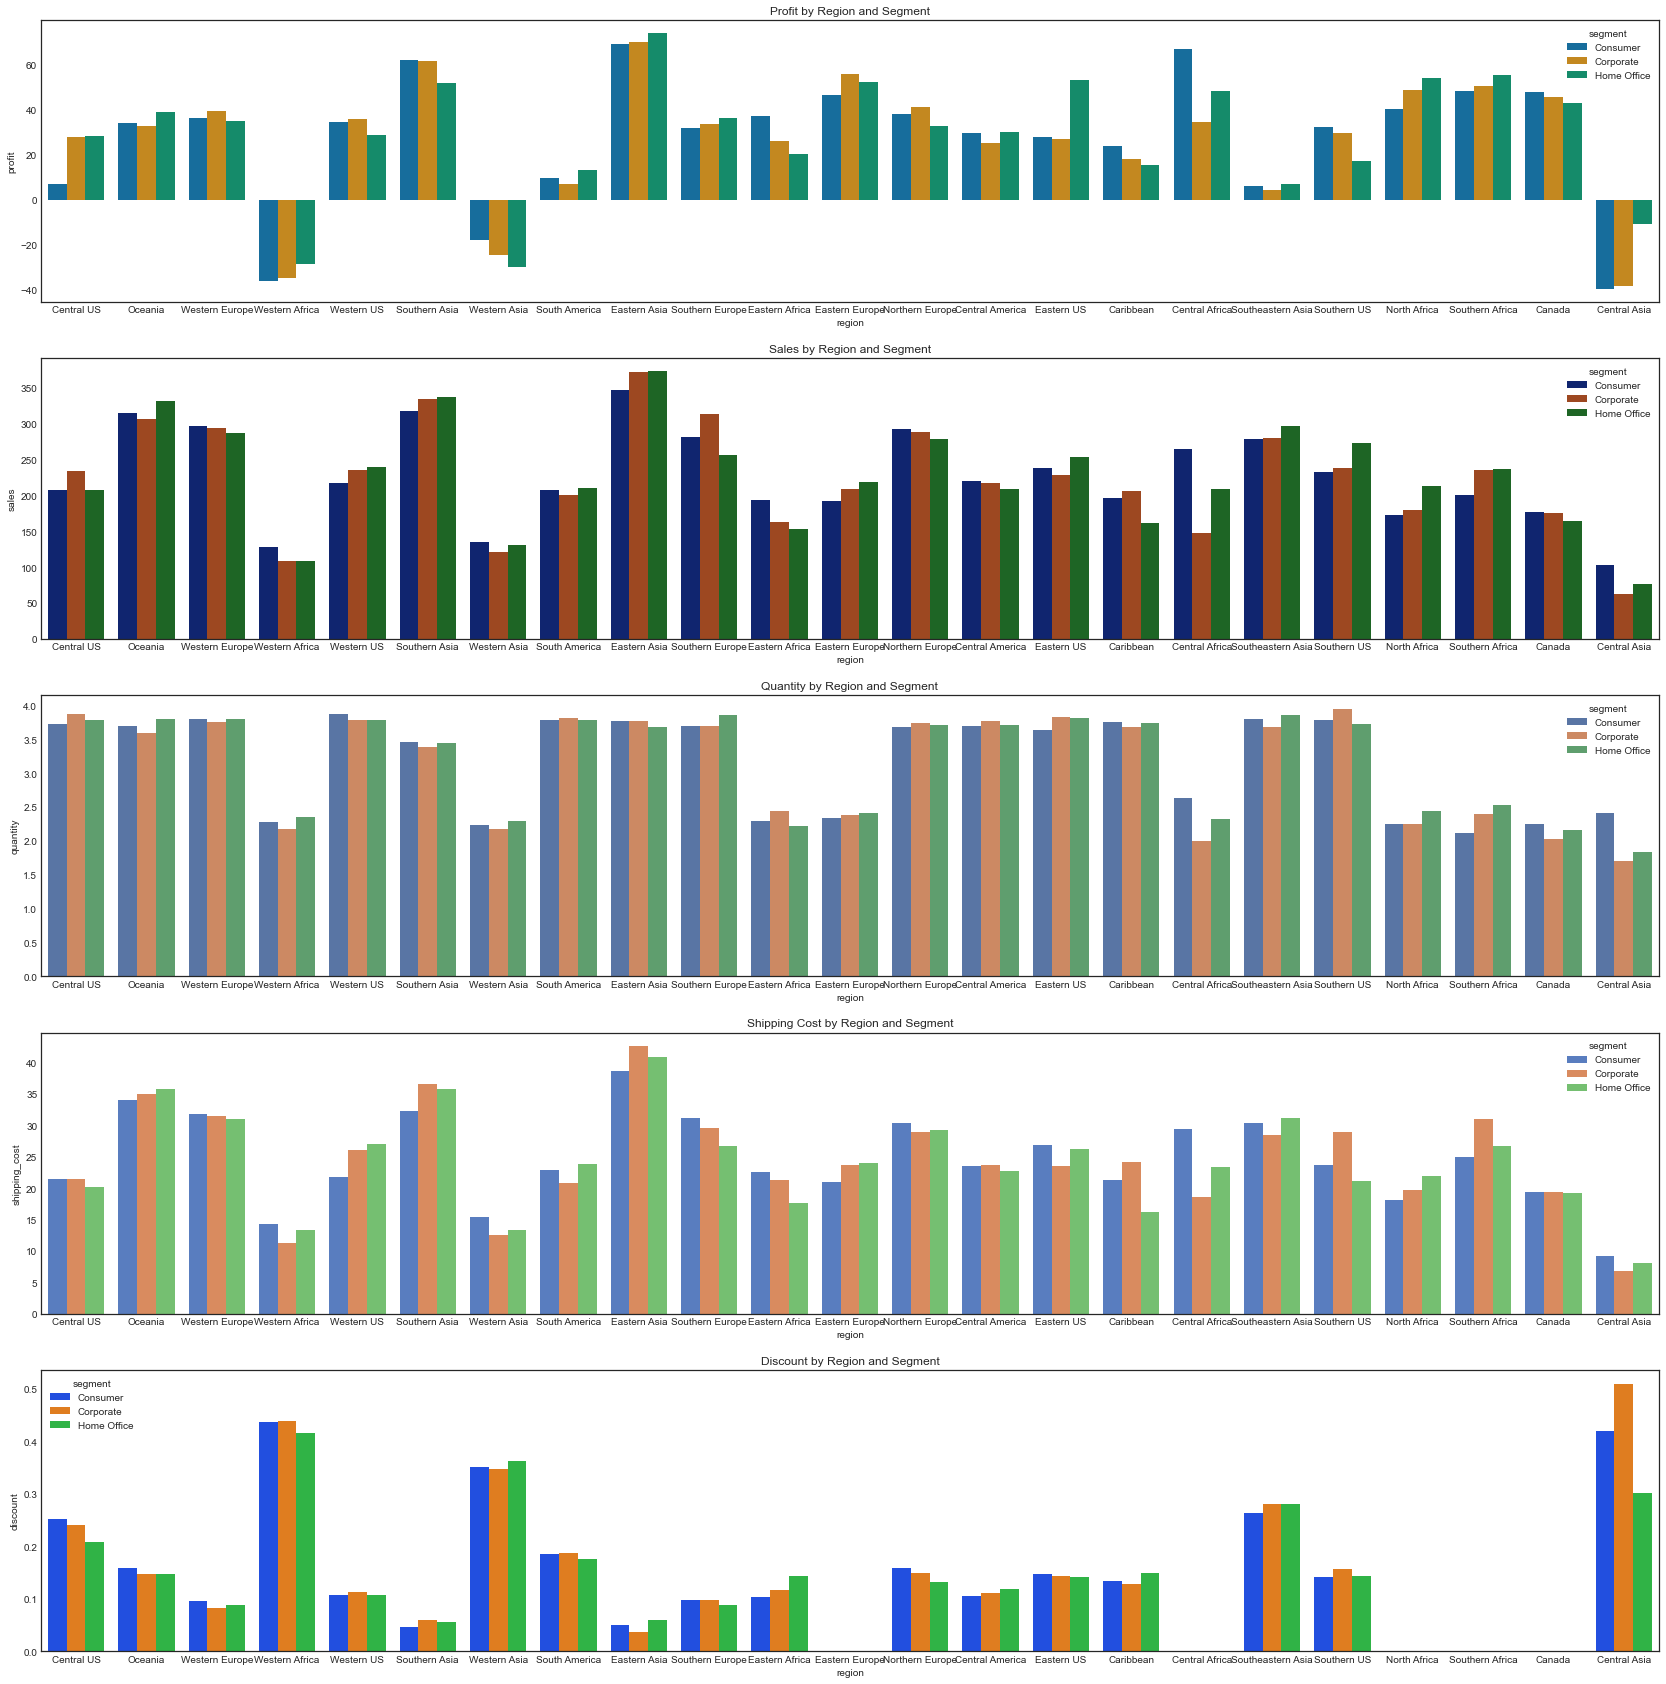

In [296]:
# profit, sales and quantity, shipping cost and discount by region
fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (29,30))
sns.barplot(ax = axes[0], data = trx, x = 'region', y = 'profit', hue = 'segment', ci = None, palette = 'colorblind')
axes[0].set_title("Profit by Region and Segment")
sns.barplot(ax = axes[1], data = trx, x = 'region', y = 'sales', hue = 'segment', ci = None, palette = 'dark' )
axes[1].set_title("Sales by Region and Segment")
sns.barplot(ax = axes[2], data = trx, x = 'region', y = 'quantity', hue = 'segment', ci = None, palette = 'deep')
axes[2].set_title("Quantity by Region and Segment")
sns.barplot(ax = axes[3], data = trx, x = 'region', y = 'shipping_cost', hue = 'segment', ci = None, palette = 'muted')
axes[3].set_title("Shipping Cost by Region and Segment")
sns.barplot(ax = axes[4], data = trx, x = 'region', y = 'discount', hue = 'segment', ci = None, palette = 'bright')
axes[4].set_title("Discount by Region and Segment")
plt.show();

- The only loss-making regions, `Western Africa`, `Western Asia` and `Central Asia` have much larger discounts of at least 0.3% compared to the rest of the regions. 

- Generally regions with highest sales, `Eastern Asia`, `Southern Asia` and `Oceania` have much higher shipping cost compared to the rest of the regions. It appears that higher shipping costs contribute to higher sales for the region. 

- Between the segments, `Consumer`, `Corporate`, and `Home Office`, there isn't any significant difference in the numerical values. 

In [297]:
#engineer column for transactions with heavy discounts >=0.3, labelled as 1 and the rest labelled as 0
trx['heavy_discount'] = [1 if x>=0.3 else 0 for x in trx['discount']]
# create a column for regions with heavy discounts
trx['heavy_discount_regions'] = [1 if ((x == 'Western Africa')|(x == 'Western Asia')|(x == 'Central Asia')) else 0 for x in trx['region']]

In [298]:
#engineer column for profitable transactions vs non-profitable transactions 
trx['non_profitable'] = [1 if x<0 else 0 for x in trx['profit']]
# create a column for profit by regions
trx['non_profitable_regions'] = [1 if ((x == 'Western Africa')|(x == 'Western Asia')|(x == 'Central Asia')) else 0 for x in trx['region']]

In [299]:
#engineer column where qty >3 and qty <3
trx['more_qty'] = [1 if x>=3 else 0 for x in trx['quantity']]
#engineer column where average region qty >3 and qty <3
trx['more_qty_regions'] = [0 if ((x == 'Western Africa')|(x == 'Western Asia')|(x == 'Central Asia')|(x == 'Eastern Africa')&(x == 'Eastern Europe')|(x=='Central Africa')|(x=='North Africa')|(x=='Southern Africa')|(x=='Canada')|(x=='Central Asia')) else 1 for x in trx['region']]

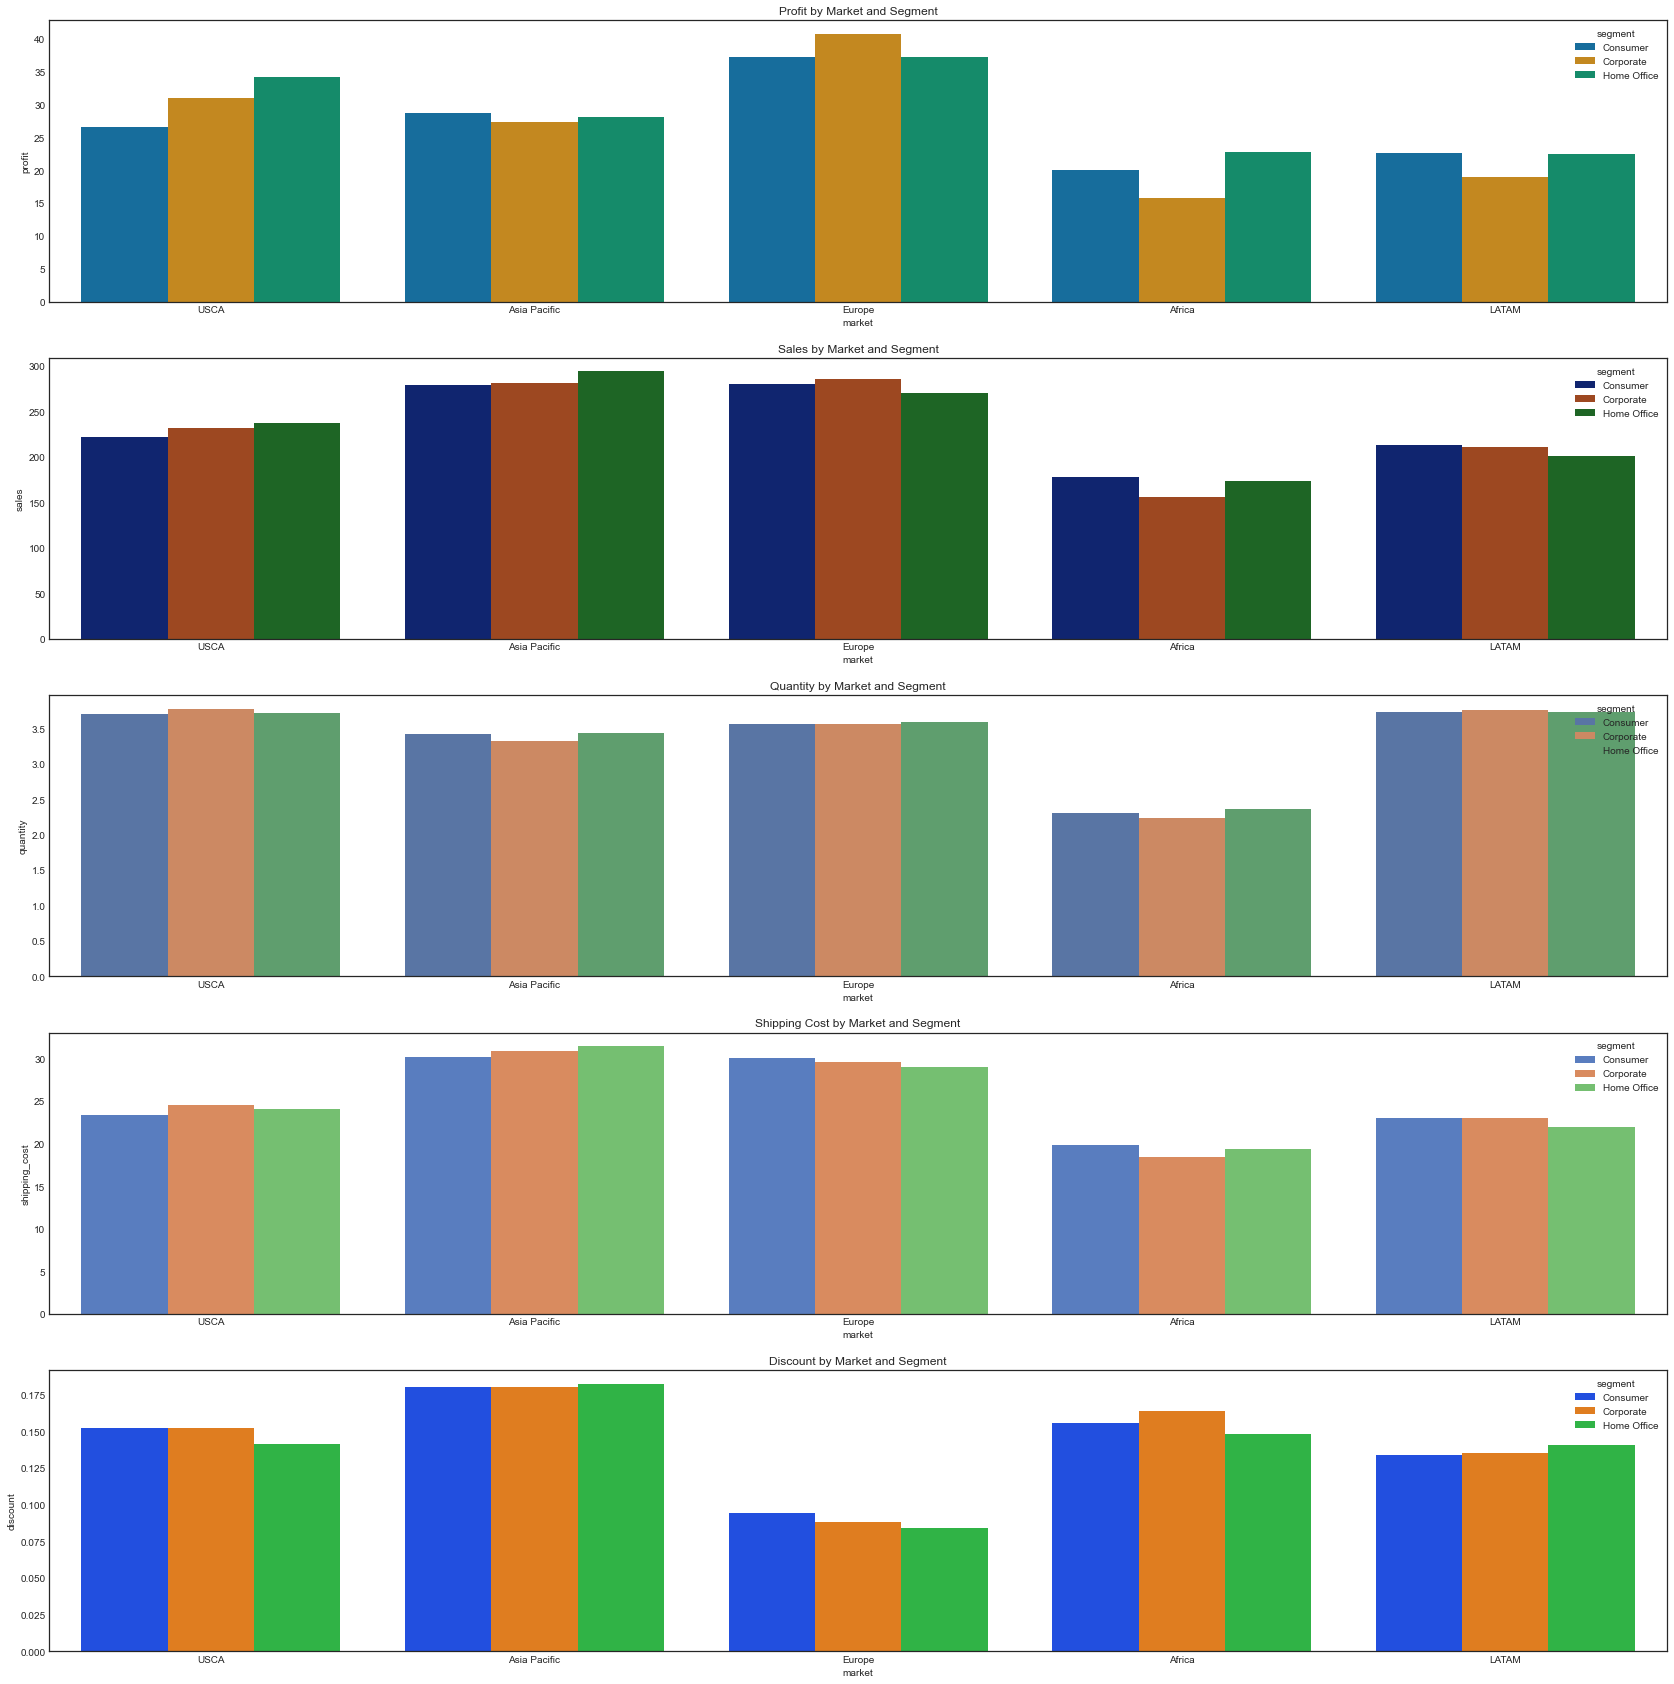

In [300]:
# profit, sales and quantity, shipping cost and discount by market
fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (29,30))
sns.barplot(ax = axes[0], data = trx, x = 'market', y = 'profit', hue = 'segment', ci = None, palette = 'colorblind')
axes[0].set_title("Profit by Market and Segment")
sns.barplot(ax = axes[1], data = trx, x = 'market', y = 'sales', hue = 'segment', ci = None, palette = 'dark' )
axes[1].set_title("Sales by Market and Segment")
sns.barplot(ax = axes[2], data = trx, x = 'market', y = 'quantity', hue = 'segment', ci = None, palette = 'deep')
axes[2].set_title("Quantity by Market and Segment")
sns.barplot(ax = axes[3], data = trx, x = 'market', y = 'shipping_cost', hue = 'segment', ci = None, palette = 'muted')
axes[3].set_title("Shipping Cost by Market and Segment")
sns.barplot(ax = axes[4], data = trx, x = 'market', y = 'discount', hue = 'segment', ci = None, palette = 'bright')
axes[4].set_title("Discount by Market and Segment")
plt.show();

- From a `market` perspective, `Europe` market is the most profitable with the least `discount` compared to the rest of the market. It seems that discount may be inversely related to sales and profit. 

- Similar to regional data, we observe the `shipping cost` to be positively correlated with `sales`.

- There is also not much significant differences between the customer `segment`s.

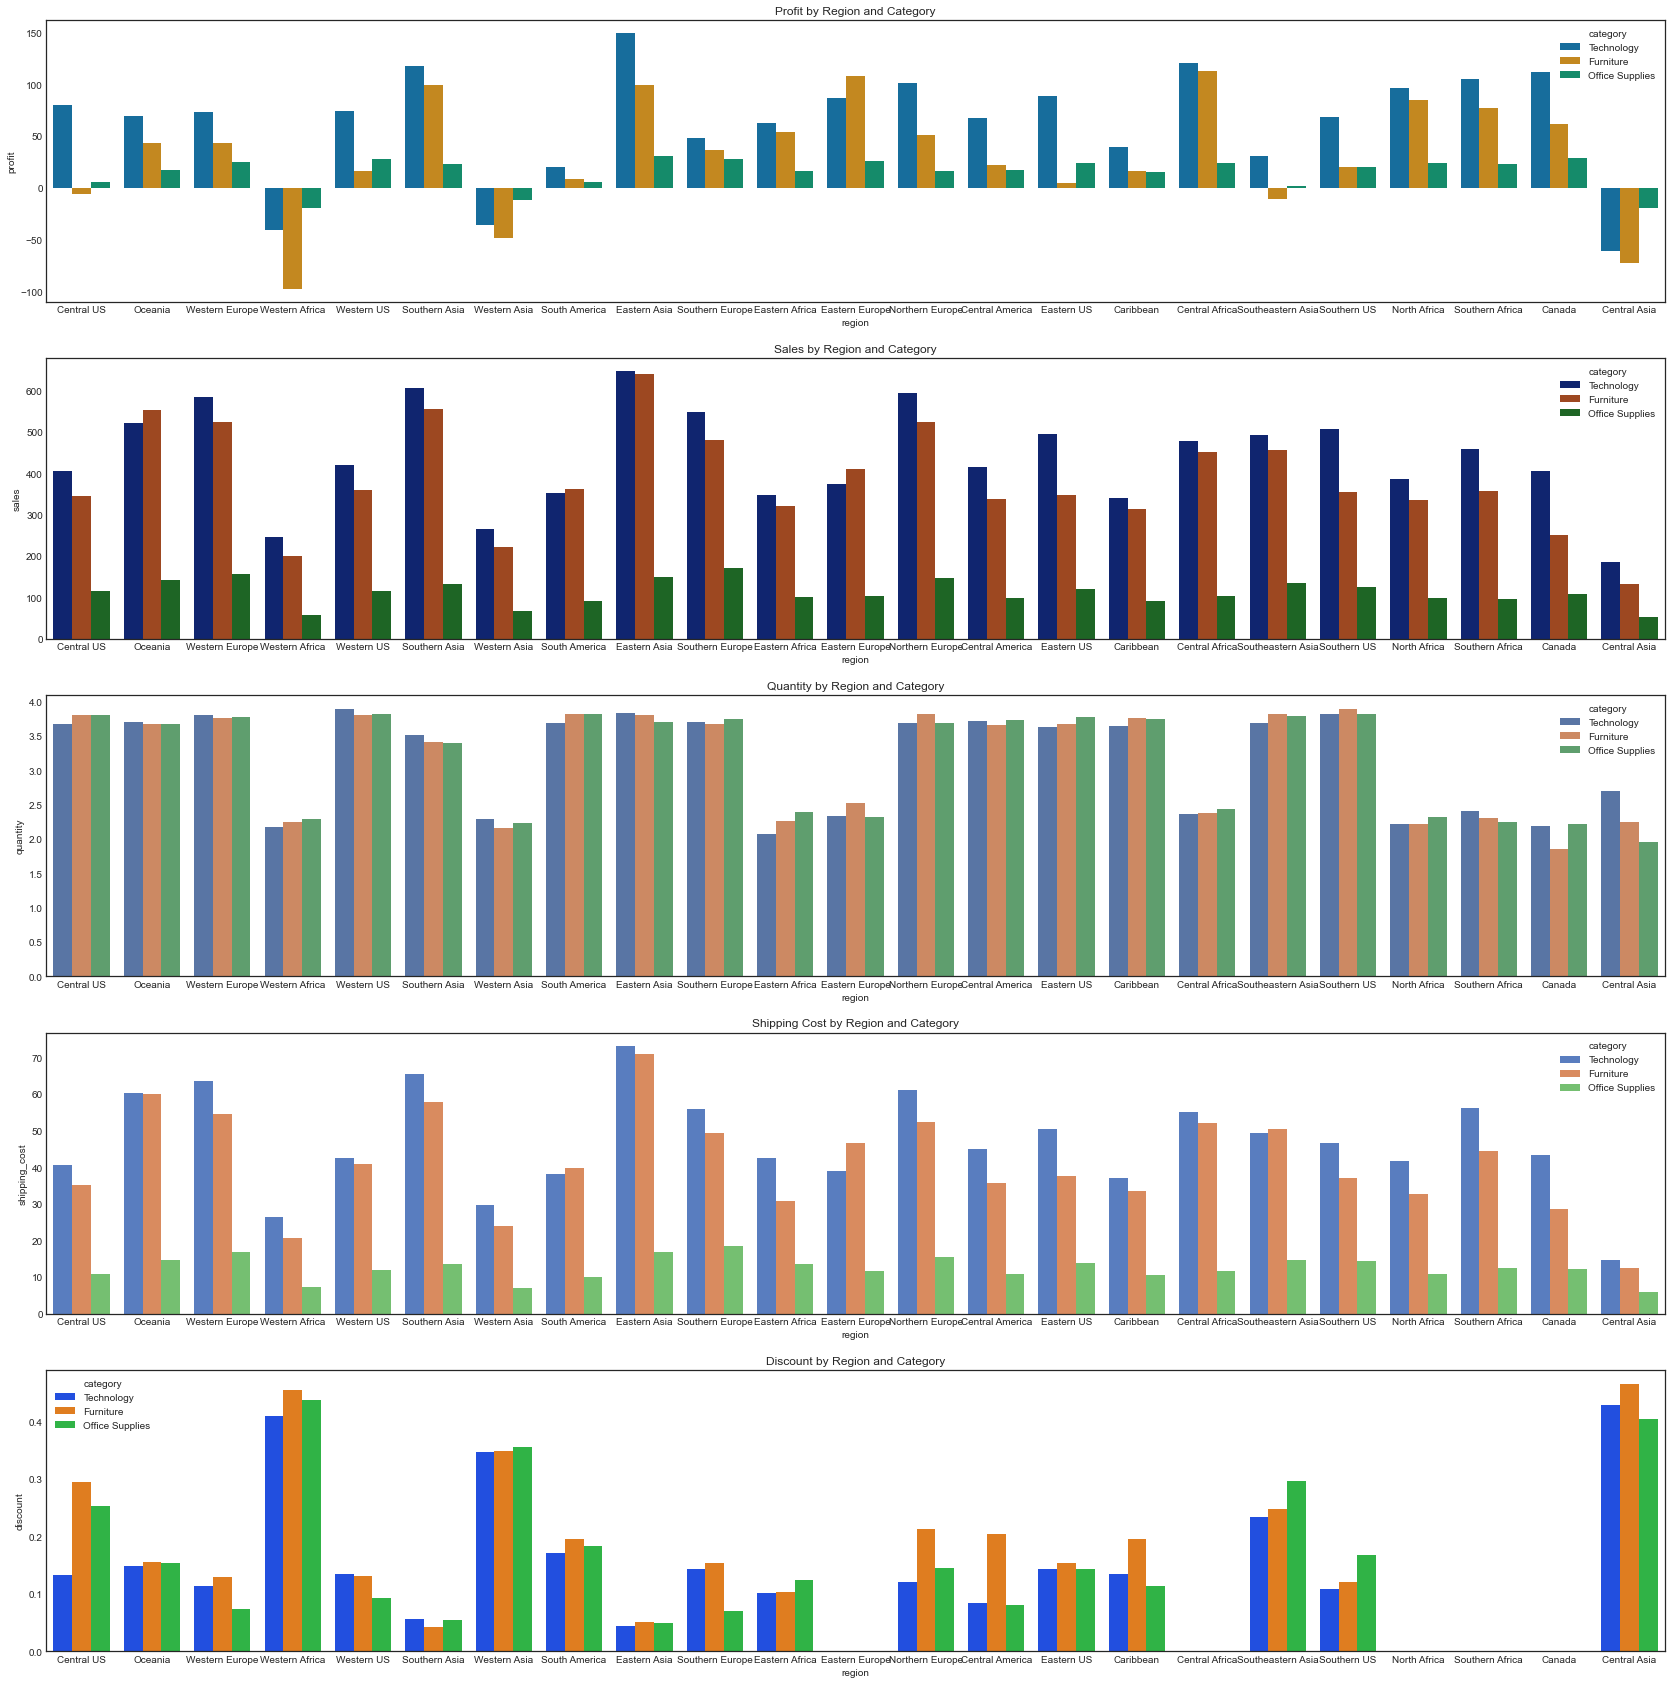

In [301]:
# profit, sales and quantity, shipping cost and discount by category and region
fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (29,30))
sns.barplot(ax = axes[0], data = trx, x = 'region', y = 'profit', hue = 'category', ci = None, palette = 'colorblind')
axes[0].set_title("Profit by Region and Category")
sns.barplot(ax = axes[1], data = trx, x = 'region', y = 'sales', hue = 'category', ci = None, palette = 'dark' )
axes[1].set_title("Sales by Region and Category")
sns.barplot(ax = axes[2], data = trx, x = 'region', y = 'quantity', hue = 'category', ci = None, palette = 'deep')
axes[2].set_title("Quantity by Region and Category")
sns.barplot(ax = axes[3], data = trx, x = 'region', y = 'shipping_cost', hue = 'category', ci = None, palette = 'muted')
axes[3].set_title("Shipping Cost by Region and Category")
sns.barplot(ax = axes[4], data = trx, x = 'region', y = 'discount', hue = 'category', ci = None, palette = 'bright')
axes[4].set_title("Discount by Region and Category")
plt.show();

- Looking at the `category`, `Technology` is generally the most profitable across all regions. `Office Supplies` generate lower revenue and hence profits, compared to `Technology` which produce higher sales, and proifts. 

- `Furniture` is the least profitable in `Western Africa`, `Western Asia` and `Central Asia`. These areas have heavily discounted prices. 

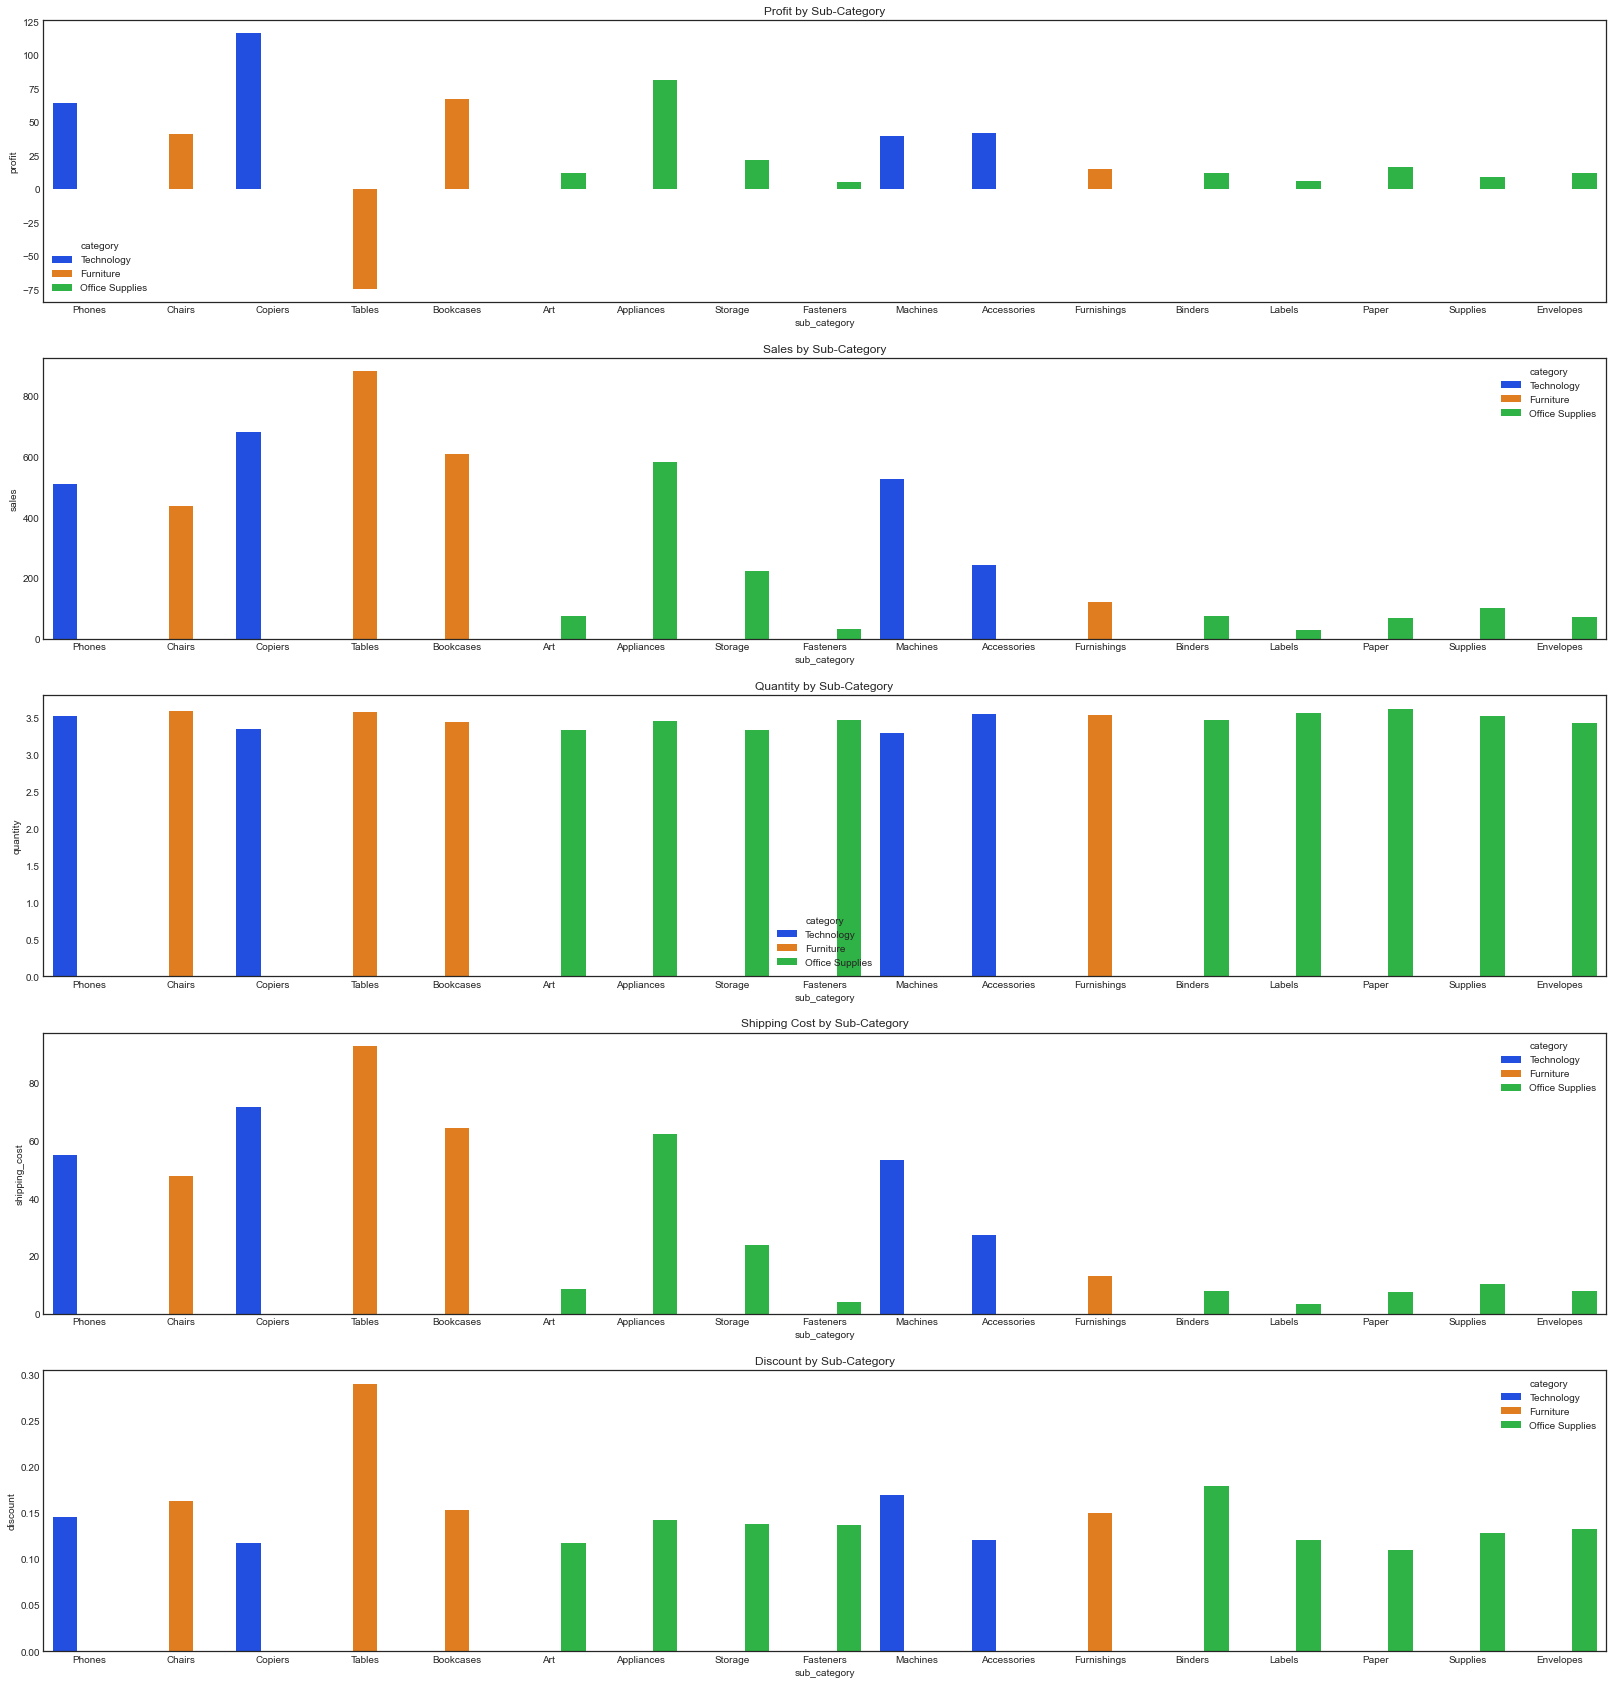

In [302]:
# overall profit, sales, qty, shipping cost and discount by subcateogry 
fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (28,30))
sns.barplot(ax = axes[0], data = trx, x='sub_category', y = 'profit', hue = 'category', ci = None, palette = 'bright')
axes[0].set_title("Profit by Sub-Category")
sns.barplot(ax = axes[1], data = trx, x='sub_category', y = 'sales', hue = 'category', ci = None, palette = 'bright')
axes[1].set_title("Sales by Sub-Category")
sns.barplot(ax = axes[2], data = trx, x='sub_category', y = 'quantity', hue = 'category',ci = None, palette = 'bright')
axes[2].set_title("Quantity by Sub-Category")
sns.barplot(ax = axes[3], data = trx, x='sub_category', y = 'shipping_cost', hue = 'category',ci = None, palette = 'bright')
axes[3].set_title("Shipping Cost by Sub-Category")
sns.barplot(ax = axes[4], data = trx, x='sub_category', y = 'discount', hue = 'category',ci = None, palette = 'bright')
axes[4].set_title("Discount by Sub-Category")
plt.show()

- `Tables` have the highest sales but are also heavily discounted. Even with high shipping cost, overall transactions with tables are loss making. It is likely that heavily discounted items are most likely loss-making transactions for the company. 

- `Copiers` are most profitable across all subcategories, and it has one the lowest discounts, compared to other subcategories. 

- `Quantity` is relatively equal across categories and subcategories. 


<u>Recency, Frequency and Monetary value (RFM) analysis</u>

RFM segmentation allows marketers to target specific clusters of customers by communicating in a way that is more relevant based on the particular customer's behaviour based on RFM of the customer. By doing so, the Company can generate much higher response rates, increased loyalty and customer lifetime value (Optimove, 2020)

We attempt to identify if there are any obvious clusters, by creating new features which represent the recency, frequency and monetary value of transactions by customers. 

*Recency*

Show how recent the customer has made a transaction with the Company. Computed by taking the latest transaction date in the dataet, and subtracting with the transaction date. 

*Frequency* 

How often the customer transacts with the company. Computed by taking the sum of transactions made by a particular customer. 

*Monetary value*

Reflects how much a customer spent on the company. Computed by taking the sum of value of all transactions the customer made with the company. 

In [303]:
# create new df for RFM analysis
R = trx.groupby(['customer_name'], as_index = False)['order_date'].max()
R.columns = ['customer_name', 'latest_trx_date']
# create recency column
latest_date = trx.order_date.max()
R['recency'] = R['latest_trx_date'].apply(lambda x : (latest_date - x).days)
R.drop('latest_trx_date', axis =1, inplace = True)
# create frequency and monetary columns
FM = trx.groupby(['customer_name'], as_index = False).agg({'order_id': lambda x:len(x),
                                                    'sales': lambda x:x.sum()}).rename(columns = {'order_id': 'frequency','sales': 'monetary_value'})
# preview R and FM
print("================== Shape of R dataset ==================")
print(R.shape)
display(R.head())
print("================== Shape of FM dataset ==================")
print(FM.shape)
display(FM.head())

================== Shape of R dataset ==================
(796, 2)


,customer_name,recency
0,Aaron Bergman,16
1,Aaron Hawkins,12
2,Aaron Smayling,23
3,Adam Bellavance,35
4,Adam Hart,2


================== Shape of FM dataset ==================
(796, 3)


,customer_name,frequency,monetary_value
0,Aaron Bergman,89,24644.62750
1,Aaron Hawkins,56,20759.51384
2,Aaron Smayling,60,14212.62840
3,Adam Bellavance,68,20186.77840
4,Adam Hart,84,21718.20142


In [304]:
# merge into main dataframe
RFM = pd.merge(R, FM)
trx = pd.merge(trx, RFM, how = 'left', left_on = 'customer_name', right_on = 'customer_name')
# preview final nerged data
print("================== Top 5 rows of merged dataset ==================")
display(trx.head())
print("================== Shape of dataset ==================")
print(trx.shape)
print("================== Null values in dataset ==================")
print(trx.isnull().sum())

================== Top 5 rows of merged dataset ==================


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,unit_price,heavy_discount,heavy_discount_regions,non_profitable,non_profitable_regions,more_qty,more_qty_regions,recency,frequency,monetary_value
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,Oklahoma City,Oklahoma,...,110.990,0,0,0,0,0,1,16,89,24644.62750
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,Wollongong,New South Wales,...,412.155,0,0,1,0,1,1,18,57,13623.24900
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,Brisbane,Queensland,...,575.019,0,0,0,0,1,1,5,77,20847.53976
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,Berlin,Berlin,...,578.502,0,0,1,0,1,1,2,81,18519.15964
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,Dakar,Dakar,...,354.120,0,1,0,1,1,0,24,56,16352.95860


================== Shape of dataset ==================
(51290, 35)
================== Null values in dataset ==================
row_id                    0
order_id                  0
order_date                0
ship_date                 0
ship_mode                 0
customer_id               0
customer_name             0
segment                   0
city                      0
state                     0
country                   0
region                    0
market                    0
category                  0
sub_category              0
product_name              0
sales                     0
quantity                  0
discount                  0
profit                    0
shipping_cost             0
order_priority            0
order_mth                 0
order_year                0
order_weekofyr            0
unit_price                0
heavy_discount            0
heavy_discount_regions    0
non_profitable            0
non_profitable_regions    0
more_qty                  0
more

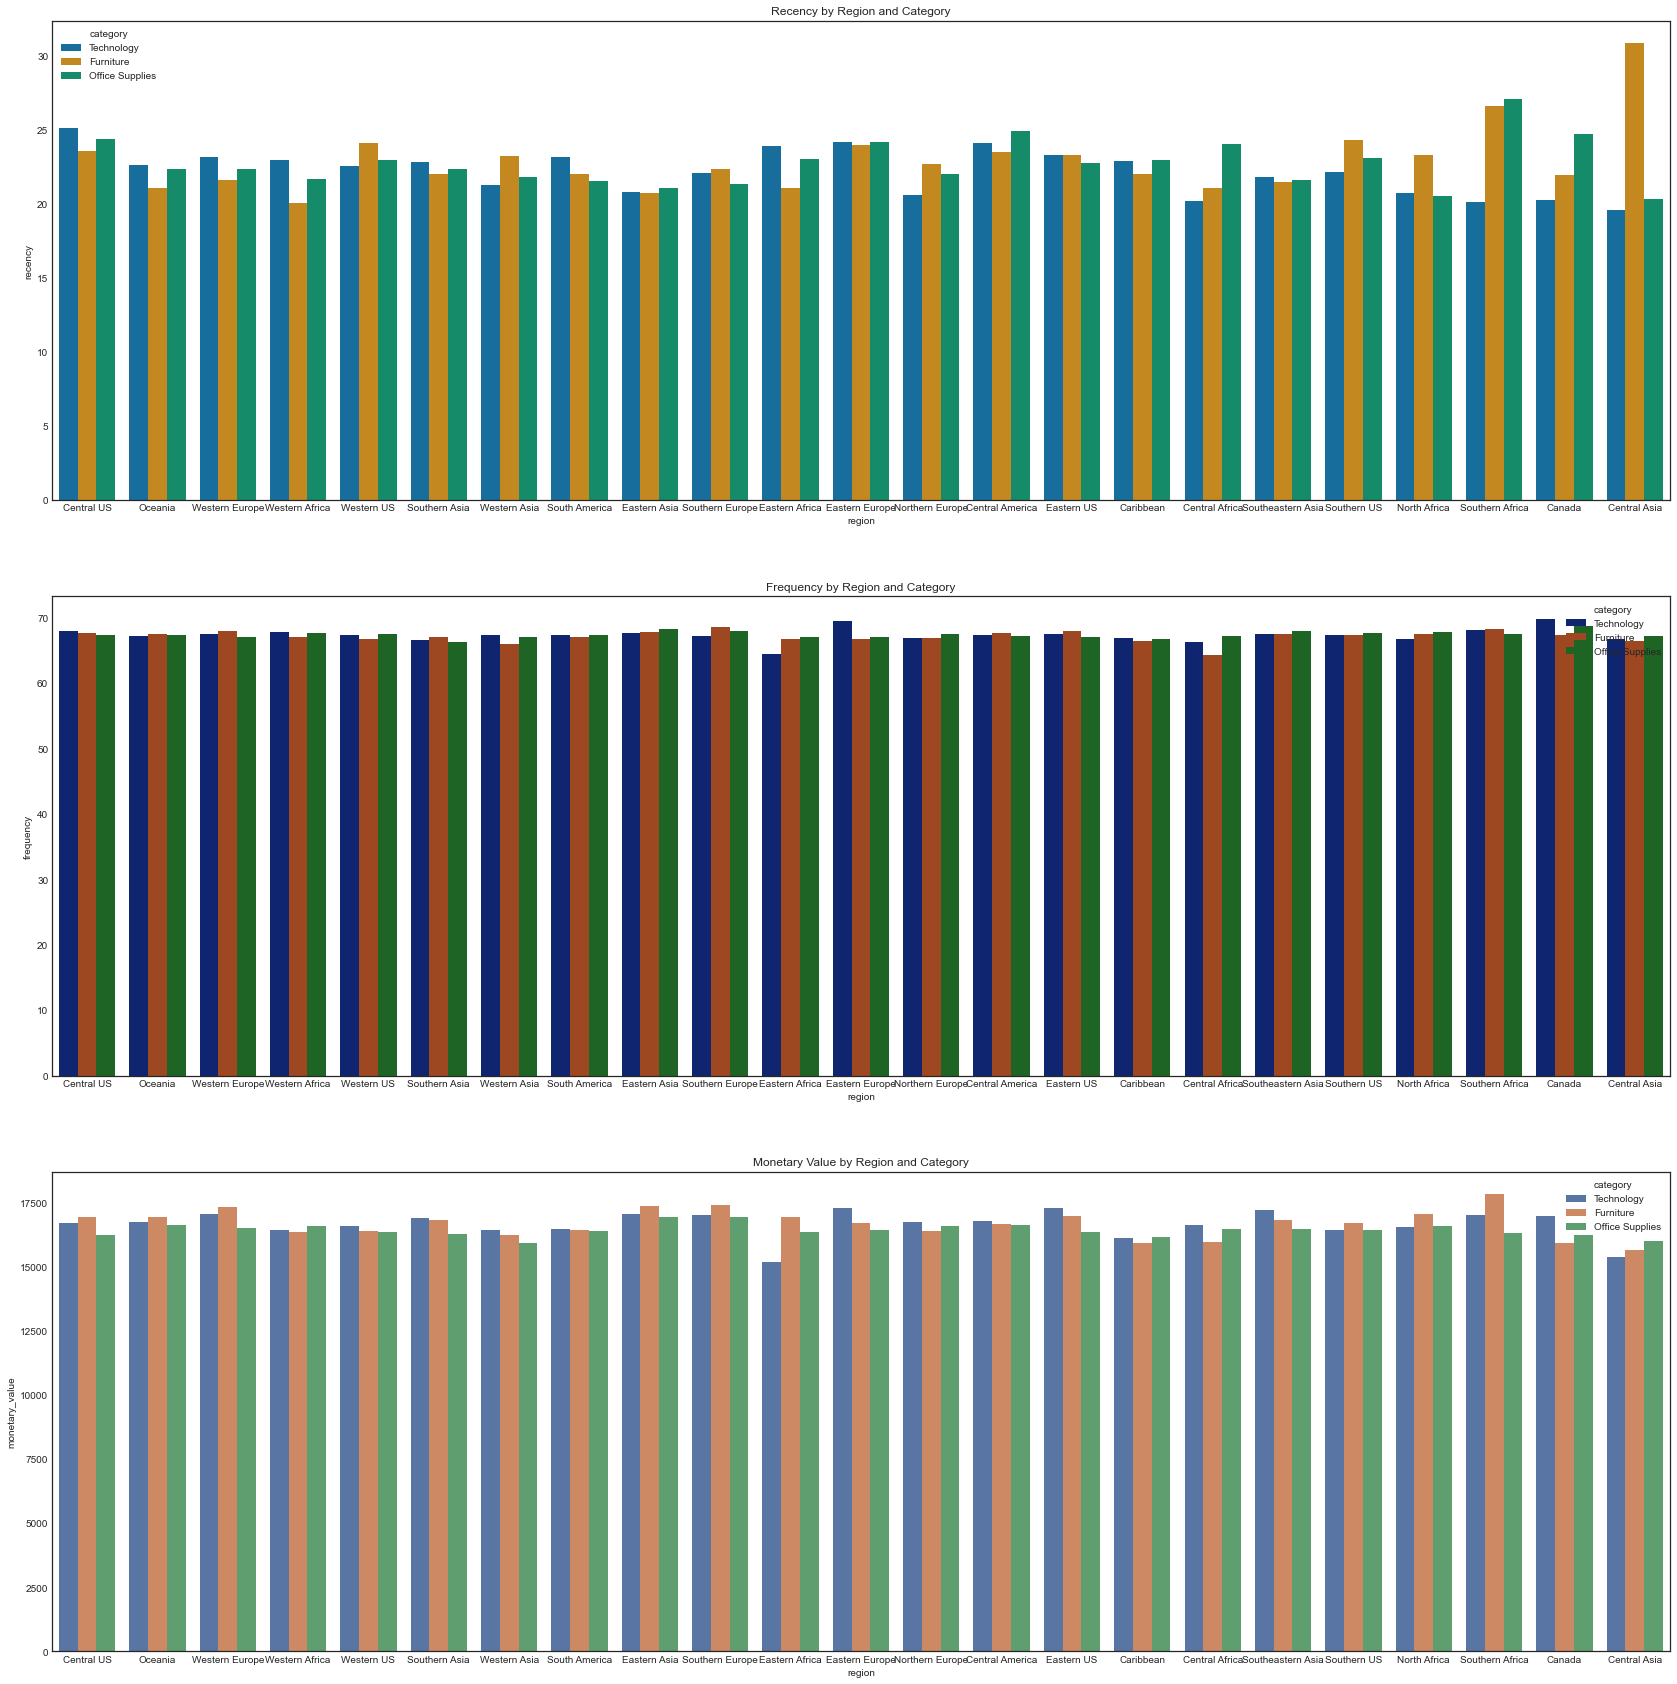

In [305]:
# RFM by region 
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (29,30))
sns.barplot(ax = axes[0], data = trx, x = 'region', y = 'recency', hue = 'category', ci = None, palette = 'colorblind')
axes[0].set_title("Recency by Region and Category")
sns.barplot(ax = axes[1], data = trx, x = 'region', y = 'frequency', hue = 'category', ci = None, palette = 'dark' )
axes[1].set_title("Frequency by Region and Category")
sns.barplot(ax = axes[2], data = trx, x = 'region', y = 'monetary_value', hue = 'category', ci = None, palette = 'deep')
axes[2].set_title("Monetary Value by Region and Category")
plt.show();

While the RFM analysis could glean more insights as to the type of customers, there seem to be no significant difference in RFM for this data, across regions and categories. 

In [306]:
# drop RFM
# trx = trx.drop(columns = ['recency', 'frequency', 'monetary_value'])

In [307]:
trx.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,unit_price,heavy_discount,heavy_discount_regions,non_profitable,non_profitable_regions,more_qty,more_qty_regions,recency,frequency,monetary_value
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,Oklahoma City,Oklahoma,...,110.990,0,0,0,0,0,1,16,89,24644.62750
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,Wollongong,New South Wales,...,412.155,0,0,1,0,1,1,18,57,13623.24900
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,Brisbane,Queensland,...,575.019,0,0,0,0,1,1,5,77,20847.53976
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,Berlin,Berlin,...,578.502,0,0,1,0,1,1,2,81,18519.15964
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,Dakar,Dakar,...,354.120,0,1,0,1,1,0,24,56,16352.95860


In [308]:
trx.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'city', 'state', 'country',
       'region', 'market', 'category', 'sub_category', 'product_name', 'sales',
       'quantity', 'discount', 'profit', 'shipping_cost', 'order_priority',
       'order_mth', 'order_year', 'order_weekofyr', 'unit_price',
       'heavy_discount', 'heavy_discount_regions', 'non_profitable',
       'non_profitable_regions', 'more_qty', 'more_qty_regions', 'recency',
       'frequency', 'monetary_value'],
      dtype='object')

### Numerical variables
Remove any outliers in numerical continuous variables in dataset, excluding binary variables that were engineered earlier.

In [309]:
# set out numerical continuous variables
trx_num = trx[['sales','profit','shipping_cost','unit_price','monetary_value']]

In [310]:
trx_num.head()

,sales,profit,shipping_cost,unit_price,monetary_value
0,221.980,62.1544,40.77,110.990,24644.62750
1,3709.395,-288.7650,923.63,412.155,13623.24900
2,5175.171,919.9710,915.49,575.019,20847.53976
3,2892.510,-96.5400,910.16,578.502,18519.15964
4,2832.960,311.5200,903.04,354.120,16352.95860


In [311]:
# remove outliers 
print("================== Shape before removing outliers ==================")
print(trx_num.shape)
trx_num_ro = trx_num[(np.abs(stats.zscore(trx_num)) < 3).all(axis=1)]
print("================== Shape after removing outliers ==================")
print(trx_num_ro.shape)

================== Shape before removing outliers ==================
(51290, 5)
================== Shape after removing outliers ==================
(48575, 5)


After removing outliers, we still have about 95% of our dataset.

In [312]:
trx_num_ro.head()

,sales,profit,shipping_cost,unit_price,monetary_value
0,221.980,62.1544,40.77,110.990,24644.6275
8,341.960,54.7136,25.27,170.980,24644.6275
9,48.712,5.4801,11.13,48.712,24644.6275
10,17.940,4.6644,4.29,5.980,24644.6275
16,12.624,-2.5248,1.97,6.312,24644.6275


In [313]:
# use current index as identifier when merging back with categorical df
trx_num_ro = trx_num_ro.reset_index()
# preview
trx_num_ro.head()

,index,sales,profit,shipping_cost,unit_price,monetary_value
0,0,221.980,62.1544,40.77,110.990,24644.6275
1,8,341.960,54.7136,25.27,170.980,24644.6275
2,9,48.712,5.4801,11.13,48.712,24644.6275
3,10,17.940,4.6644,4.29,5.980,24644.6275
4,16,12.624,-2.5248,1.97,6.312,24644.6275


### Categorical variables
For categorical variables, we one-hot-encode it. 

In [314]:
def get_dum(df, columns):
    '''function that gets dummies for columns stated and append to the dataframe'''
    for col in columns:
        trx_dummy = pd.get_dummies(df[col], prefix = f'{col}')
        df = pd.concat([df, trx_dummy], axis = 1)
    return df

In [315]:
# select columns that will be one hot encoded
columns = ['category', 'ship_mode', 'region', 'segment', 'market', 'order_priority']
# apply function
trx_cat = get_dum(trx, columns)

In [316]:
trx_cat.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,segment_Home Office,market_Africa,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,Oklahoma City,Oklahoma,...,0,0,0,0,0,1,0,1,0,0
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,Wollongong,New South Wales,...,0,0,1,0,0,0,1,0,0,0
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,Brisbane,Queensland,...,0,0,1,0,0,0,0,0,0,1
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,Berlin,Berlin,...,1,0,0,1,0,0,0,0,0,1
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,Dakar,Dakar,...,0,1,0,0,0,0,1,0,0,0


In [317]:
# drop columns that will not be one hot encoded
trx_cat = trx_cat.drop(columns = ['row_id','order_id','order_date','ship_date','customer_id','customer_name','city','state','country','sub_category','product_name','order_mth','order_year','order_weekofyr'])
# drop columns that have already been one hot encoded
trx_cat = trx_cat.drop(columns = ['category', 'ship_mode', 'region', 'segment', 'market', 'order_priority'])

In [318]:
trx_cat.columns

Index(['sales', 'quantity', 'discount', 'profit', 'shipping_cost',
       'unit_price', 'heavy_discount', 'heavy_discount_regions',
       'non_profitable', 'non_profitable_regions', 'more_qty',
       'more_qty_regions', 'recency', 'frequency', 'monetary_value',
       'category_Furniture', 'category_Office Supplies', 'category_Technology',
       'ship_mode_First Class', 'ship_mode_Same Day', 'ship_mode_Second Class',
       'ship_mode_Standard Class', 'region_Canada', 'region_Caribbean',
       'region_Central Africa', 'region_Central America',
       'region_Central Asia', 'region_Central US', 'region_Eastern Africa',
       'region_Eastern Asia', 'region_Eastern Europe', 'region_Eastern US',
       'region_North Africa', 'region_Northern Europe', 'region_Oceania',
       'region_South America', 'region_Southeastern Asia',
       'region_Southern Africa', 'region_Southern Asia',
       'region_Southern Europe', 'region_Southern US', 'region_Western Africa',
       'region_Western A

In [319]:
#drop columns that will be appended by the updated trx numberical continuous variables
trx_cat = trx_cat.drop(columns = ['sales','profit','shipping_cost','unit_price','monetary_value'])

In [320]:
# get the index values for merging with numerical variables dataframe
trx_cat = trx_cat.reset_index() 

In [321]:
# preview and check shape
display(trx_cat.head())
print("================== Shape of trx_cat dataset ==================")
print(trx_cat.shape)

,index,quantity,discount,heavy_discount,heavy_discount_regions,non_profitable,non_profitable_regions,more_qty,more_qty_regions,recency,...,segment_Home Office,market_Africa,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium
0,0,2,0.0,0,0,0,0,0,1,16,...,0,0,0,0,0,1,0,1,0,0
1,1,9,0.1,0,0,1,0,1,1,18,...,0,0,1,0,0,0,1,0,0,0
2,2,9,0.1,0,0,0,0,1,1,5,...,0,0,1,0,0,0,0,0,0,1
3,3,5,0.1,0,0,1,0,1,1,2,...,1,0,0,1,0,0,0,0,0,1
4,4,8,0.0,0,1,0,1,1,0,24,...,0,1,0,0,0,0,1,0,0,0


================== Shape of trx_cat dataset ==================
(51290, 53)


###  Merge dataframe with numerical and categorical variables together

In [322]:
# merge with categorical var based on index (merge based on trx_num as index has changed from removal of outliers)
trx = pd.merge(trx_num_ro, trx_cat, how = 'left', left_on = 'index', right_on = 'index')

In [323]:
# drop index, since it's not relevant anymore 
trx.drop(columns = ['index'], inplace = True)

In [324]:
# preview and check shape
print("================== Top 5 rows of trx dataset ==================")
display(trx.head())
print("================== Shape of trx dataset ==================")
print(trx.shape) 

,sales,profit,shipping_cost,unit_price,monetary_value,quantity,discount,heavy_discount,heavy_discount_regions,non_profitable,...,segment_Home Office,market_Africa,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium
0,221.980,62.1544,40.77,110.990,24644.6275,2,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,341.960,54.7136,25.27,170.980,24644.6275,2,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,48.712,5.4801,11.13,48.712,24644.6275,1,0.2,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,17.940,4.6644,4.29,5.980,24644.6275,3,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,12.624,-2.5248,1.97,6.312,24644.6275,2,0.2,0,0,1,...,0,0,0,0,0,1,0,0,1,0


================== Shape of trx dataset ==================
(48575, 57)


### Save data

In [325]:
trx.to_csv("../data/trx_clean.csv", index = False)

### References

"RFM Segmentation" (Optimove, 2020)
https://www.optimove.com/resources/learning-center/rfm-segmentation